### V-bottom Well Motility Assay and Line Scan Analysis

This notebook processes and analyzes motility assays of *Chlamydomonas* strains seeded in 96- or 384-well plates with v-bottom wells, using images captured by a Phenotype-o-mat setup. The notebook performs several key functions:

1. **GIF Creation from Video Files**: 
   - Extracts AVI video frames from experiments, applies time stamps, and stitches them into time-lapsed GIFs for visual inspection of motility over time.

2. **Line Scan Intensity Analysis**: 
   - Conducts horizontal line scans across the wells to quantify cell density, differentiating between non-motile cells (which sink to the bottom of the well) and motile cells (which remain suspended). Metrics such as minimum intensity, average intensity, and their differences/ratios are computed for further analysis.

3. **Visualization and Statistical Testing**:
   - Annotates and displays the processed well images, overlays line scan plots, and performs one-way ANOVA and post-hoc Tukey tests to evaluate differences between treatments across multiple strains.

Output from this notebook was used to generate figures and statistical analyses related to cell motility for the study, contributing to Figures 2 and 4 in the [publication](https://doi.org/10.57844/arcadia-fe2a-711e).

---


### Purpose:
This code processes a set of `.avi` video files, adds timestamps based on the file names, and combines them into an animated GIF for visualization.

### Key Steps:
1. **Timestamp Extraction**:
   - Extracts timestamps from video filenames using regex to calculate time differences between frames.
   
2. **Video Processing**:
   - Reads each video file, applies a timestamp to each frame, and collects frames for GIF creation.
   
3. **GIF Creation**:
   - Combines processed frames into a single animated GIF and saves the output.

4. **ZIP File Handling**:
   - Extracts video files from a specified ZIP archive before processing.

5. **Displaying Output**:
   - Displays the final GIF within a Jupyter notebook.

### Outputs:
- **Animated GIF**: A GIF created from the processed video frames, saved to the specified output path.

### Libraries:
- `cv2`, `PIL`, `imageio`, `os`, `re`, `zipfile`, `IPython.display`.

This notebook automates the process of extracting videos from a ZIP file, timestamping frames, and generating a time-lapsed GIF for easy visualization.


In [27]:
import cv2
from PIL import Image, ImageDraw, ImageFont
import os
import numpy as np
from datetime import datetime, timedelta
import re
import imageio
from IPython.display import Image as IPImage, display
import zipfile

def add_timestamp(img, timestamp):
    pil_img = Image.fromarray(img)
    draw = ImageDraw.Draw(pil_img)
    font_path = "/Library/Fonts/Arial.ttf"
    font_size = 32
    font = ImageFont.truetype(font_path, font_size)
    text_position = (10, 10)
    text_color = (255, 255, 255)
    draw.text(text_position, timestamp, font=font, fill=text_color)
    return np.array(pil_img)

def extract_timestamp(filename):
    match = re.search(r'_(\d+)\.avi$', filename)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"No numeric timestamp found in filename: {filename}")

def process_videos(input_folder, output_gif):
    video_files = [f for f in os.listdir(input_folder) if f.endswith('.avi')]
    if not video_files:
        print("No .avi files found in the directory.")
        return

    video_files.sort(key=extract_timestamp)

    print(f"Processing {len(video_files)} files...")

    gif_frames = []
    base_time = extract_timestamp(video_files[0])

    for filename in video_files:
        current_time = extract_timestamp(filename)
        timestamp_diff = current_time - base_time
        timestamp = str(timedelta(seconds=timestamp_diff))
        
        cap = cv2.VideoCapture(os.path.join(input_folder, filename))
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_with_timestamp = add_timestamp(frame, timestamp)
            gif_frames.append(frame_with_timestamp)
        cap.release()
    
    # Save as GIF
    imageio.mimsave(output_gif, gif_frames, fps=20)
    print("GIF creation complete.")

# Example usage
zip_file_path = '../data/vbottom_avi/vbottom_motility_strains.zip'
extracted_folder = '../data/vbottom_avi/Strains_extracted'
output_gif = '../results/vbottom_strain_output_video.gif'

# Ensure the output directory exists
output_dir = os.path.dirname(output_gif)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Extract the .zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)
    print(f"Files extracted to: {extracted_folder}")

# Process the videos from the extracted folder
process_videos(extracted_folder, output_gif)

# Display the output GIF in the notebook
#display(IPImage(filename=output_gif))

Files extracted to: ../data/vbottom_avi/Strains_extracted
Processing 96 files...
GIF creation complete.


## Data Analysis - Intensity line scan (Figure 2)
Prior to this analysis, I opened the last single-frame AVI acquired in the dataset in FIJI and cropped the image to only include the wells of interest. I then saved the image as a TIF. 

### Purpose:
This code performs line scan analyses on a 96- or 384-well v-bottom plate of *Chlamydomonas* strains to measure cell density and motility defects. It visualizes, compares, and exports data for statistical analysis across three strains (`cc-125`, `cc-2670`, `cc-3707`).

### Key Steps:
1. **Image Handling**:
   - Loads a TIFF image of a plate and identifies well centers.
   - Performs horizontal line scans through each well, aligning scans by minimum intensity (representing non-motile cells).

2. **Visualization**:
   - Draws scanned lines and sample labels on the image.
   - Saves and displays marked images with scan lines and detailed well information.

3. **Data Processing**:
   - Computes pixel intensity averages for positions 33-37, minimum intensity values, and the difference/ratio between them.
   - Exports line scan results to CSV.

4. **Statistical Analysis**:
   - Conducts Mann-Whitney U tests for pairwise strain comparisons of intensity differences, ratios, and minimum values.
   - Applies Bonferroni correction for multiple comparisons and exports results to CSV.

5. **Plotting**:
   - Generates overlaid plots of line scans for each strain and saves as SVG.

### Outputs:
- **Marked Images**: PNG files with scanned lines and labels.
- **Plots**: SVG showing overlaid line scans for each strain.
- **Data Files**: CSVs with line scan intensities and statistical comparison results.

### Libraries:
- `tifffile`, `opencv`, `matplotlib`, `pandas`, `scipy.stats`, `arcadia-pycolor`.

This notebook provides a reproducible pipeline for visualizing, analyzing, and statistically comparing motility data across *Chlamydomonas* strains.

Image opened successfully!


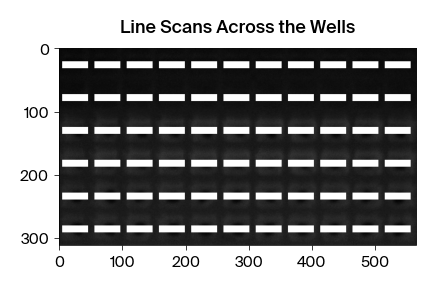

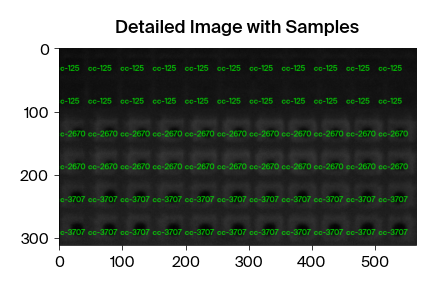

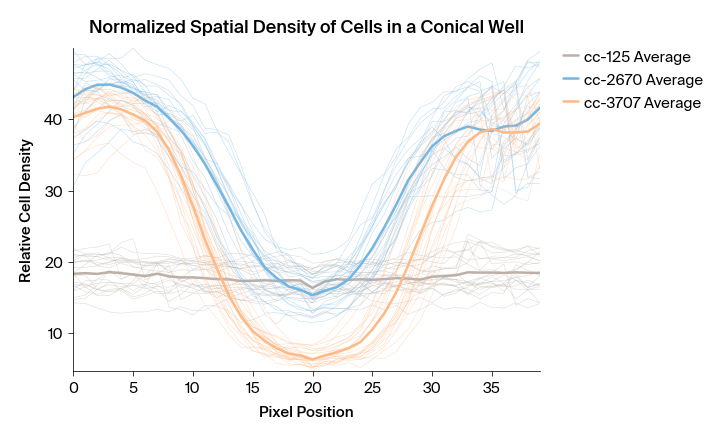

Marked-up image saved to: ../results/linescan_strain_results/marked_well_lines.png
Detailed image saved to: ../results/linescan_strain_results/marked_details.png
Overlayed plot saved as SVG to: ../results/linescan_strain_results/overlayed_plot_all_strains.svg
Line scan intensities saved to: ../results/linescan_strain_results/line_scans.csv
CSV with pixel position data, averages, minimums, differences, and fractions saved to: ../results/linescan_strain_results/pixel_33_37_min_comparisons.csv
Pairwise Comparison of Pixel 33-37 Avg vs Minimum (Mann-Whitney U test, Bonferroni corrected p-values):
                         p-value
cc-125 vs cc-2670   1.437684e-08
cc-125 vs cc-3707   1.437684e-08
cc-2670 vs cc-3707  7.311605e-07
Pairwise Comparison of Pixel 33-37 Fraction Avg vs Minimum (Mann-Whitney U test, Bonferroni corrected p-values):
                         p-value
cc-125 vs cc-2670   1.439361e-08
cc-125 vs cc-3707   1.439361e-08
cc-2670 vs cc-3707  1.439361e-08
Pairwise Comparison of 

/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_17068/3066773809.py:268: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pairwise_pixel_diff_results_corrected = pairwise_pixel_diff_results_corrected.applymap(lambda p: min(p, 1.0))  # p-values cannot exceed 1.0
/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_17068/3066773809.py:288: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pairwise_pixel_fraction_results_corrected = pairwise_pixel_fraction_results_corrected.applymap(lambda p: min(p, 1.0))  # p-values cannot exceed 1.0
/var/folders/j2/9j8mjlj13cscwjnxpb_68wg80000gn/T/ipykernel_17068/3066773809.py:308: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pairwise_min_results_corrected = pairwise_min_results_corrected.applymap(lambda p: min(p, 1.0))  # p-values cannot exceed 1.0


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line
import cv2
import os
import pandas as pd
import arcadia_pycolor as apc
from PIL import Image, ImageDraw, ImageFont
import tifffile as tiff
import scipy.stats as stats
from itertools import combinations

# Set the default matplotlib styles using arcadia-pycolor
apc.mpl.setup()

# Correct path to the TIFF file
image_path = '../data/vbottom_avi/cropped_final_frame/algae_growth_curve_00000_1722972387-1_FinalFrame_Crop.tif'

# Verify that the file exists
if not os.path.exists(image_path):
    print(f"Error: File not found at path {image_path}")
    sys.exit()

# Attempt to open the image using tifffile
try:
    image = tiff.imread(image_path)
    print("Image opened successfully!")
except IOError:
    print("Error: Could not open image with tifffile.")
    sys.exit()

# Convert the image to grayscale if it's not already (if needed)
if len(image.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define the number of rows and columns in the 96-well plate (now 6 rows and 11 columns)
num_rows = 6
num_cols = 11

# Diameter and scan width of the wells
well_diameter = 70
scan_width = 10
scan_length = 40  # Updated scan length

# Identify the centers of the wells
height, width = image.shape
row_spacing = height // num_rows
col_spacing = width // num_cols

# Calculate precise center positions of the wells
well_centers = [(int((row + 0.5) * row_spacing), int((col + 0.5) * col_spacing)) for row in range(num_rows) for col in range(num_cols)]

# Create a list to store the line scan results
line_scans = []

# Create a copy of the image to draw the lines on
image_with_lines = image.copy()
image_with_details = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

# Updated labels for each well
labels = [
    ['cc-125'] * num_cols,
    ['cc-125'] * num_cols,
    ['cc-2670'] * num_cols,
    ['cc-2670'] * num_cols,
    ['cc-3707'] * num_cols,
    ['cc-3707'] * num_cols
]

# Flatten the labels for easier indexing
flat_labels = [label for row in labels for label in row]

# Load the Suisse Int'l font
try:
    font_path = '/path/to/SuisseIntl-Regular.ttf'  # Replace with the actual path to the Suisse Int'l font file
    font = ImageFont.truetype(font_path, 12)
except IOError:
    print("Suisse Int'l font not found. Using default font.")
    font = ImageFont.load_default()

# Convert the image_with_details to PIL format for text drawing
image_with_details_pil = Image.fromarray(cv2.cvtColor(image_with_details, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(image_with_details_pil)

# Perform line scans, realign, and normalize data
for i, (center_y, center_x) in enumerate(well_centers):
    # Calculate the start and end points of the scan line
    start_x = max(center_x - scan_length // 2, 0)
    end_x = min(center_x + scan_length // 2, width - 1)
    
    # Perform a horizontal line scan across the center with a width of scan_width
    line_intensity = []
    for offset in range(-scan_width // 2, scan_width // 2 + 1):
        rr, cc = line(center_y + offset, start_x, center_y + offset, end_x)
        line_intensity.append(image[rr, cc])
    
    # Ensure all scans are of the same length by trimming to scan_length
    line_intensity = [scan[:scan_length] for scan in line_intensity]
    line_intensity = np.mean(line_intensity, axis=0)
    
    # Realign the line scan by aligning the minimum point within a broader search region
    broader_search_indices = np.arange(10, 30)  # Adjusted for new scan length
    min_index = broader_search_indices[np.argmin(line_intensity[broader_search_indices])]
    shift = (scan_length // 2) - min_index  # Align the minimum point to the center
    line_intensity = np.roll(line_intensity, shift)
    
    # Store the realigned and normalized result
    line_scans.append(line_intensity)
    
    # Draw the line on the image for visualization
    for offset in range(-scan_width // 2, scan_width // 2 + 1):
        rr, cc = line(center_y + offset, start_x, center_y + offset, end_x)
        image_with_lines[rr, cc] = 255
    
    # Add sample details to the detailed image using PIL
    draw.text((center_x - 30, center_y), flat_labels[i], font=font, fill=(0, 255, 0))

# Convert back to OpenCV format
image_with_details = cv2.cvtColor(np.array(image_with_details_pil), cv2.COLOR_RGB2BGR)

# Save the images with the lines and details
marked_image_path = '../results/linescan_strain_results/marked_well_lines.png'
details_image_path = '../results/linescan_strain_results/marked_details.png'
os.makedirs(os.path.dirname(marked_image_path), exist_ok=True)
cv2.imwrite(marked_image_path, image_with_lines)
cv2.imwrite(details_image_path, image_with_details)

# Display the images with the scanned lines and details
plt.imshow(image_with_lines, cmap='gray')
plt.title('Line Scans Across the Wells')
plt.show()

plt.imshow(image_with_details)
plt.title('Detailed Image with Samples')
plt.show()

# Define the color scheme for each strain (no treatments, just strain colors)
strain_color_map = {
    'cc-125': '#BAB0A8',
    'cc-2670': '#73B5E3',
    'cc-3707': '#FFB984'
}

# Find the global minimum and maximum for y-axis across all scans
y_min = min([min(scan) for scan in line_scans])
y_max = max([max(scan) for scan in line_scans])

# Create a single plot with all three strains' measurements overlaid
fig, ax = plt.subplots(figsize=(10, 6))

for strain in ['cc-125', 'cc-2670', 'cc-3707']:
    # Filter the scans that match the current strain
    strain_scans = [line_scans[i] for i in range(len(line_scans)) if flat_labels[i] == strain]
    
    # Plot the individual scans
    for scan in strain_scans:
        ax.plot(scan, color=strain_color_map[strain], linewidth=0.5, alpha=0.5)
    
    # Plot the average scan for the strain
    if strain_scans:
        avg_scan = np.mean(strain_scans, axis=0)
        ax.plot(avg_scan, color=strain_color_map[strain], linewidth=2.5, label=f'{strain} Average')

# Set consistent limits for x and y axes
ax.set_xlim(0, scan_length - 1)
ax.set_ylim(y_min, y_max)

ax.set_title('Normalized Spatial Density of Cells in a Conical Well', fontstyle='normal')
ax.set_xlabel('Pixel Position')
ax.set_ylabel('Relative Cell Density')

# Place the legend outside of the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()

# Save the plot as an SVG file
overlayed_plot_path = '../results/linescan_strain_results/overlayed_plot_all_strains.svg'
plt.savefig(overlayed_plot_path, format='svg')

plt.show()

# Convert the line scan results to a DataFrame and export as CSV
line_scans_df = pd.DataFrame(line_scans).T
well_labels = [f'Well {row+1}-{col+1}' for row in range(num_rows) for col in range(num_cols)]
line_scans_df.columns = well_labels

csv_path = '../results/linescan_strain_results/line_scans.csv'
line_scans_df.to_csv(csv_path, index=False)

print(f"Marked-up image saved to: {marked_image_path}")
print(f"Detailed image saved to: {details_image_path}")
print(f"Overlayed plot saved as SVG to: {overlayed_plot_path}")
print(f"Line scan intensities saved to: {csv_path}")

# Define the regions for comparison (shifted to pixel positions 33-37)
pixel_range = range(33, 38)  # Range of pixels between 33 and 37

# Create lists to store the values for each well
pixel_33_37_values = []
pixel_33_37_avg_list = []
min_value_list = []
difference_list = []
fraction_list = []

# Loop over each scan to calculate the statistics
for scan in line_scans:
    # Intensity values for pixels 33-37
    pixel_33_37 = scan[33:38]
    pixel_33_37_values.append(list(pixel_33_37))  # Save the pixel values
    
    # Calculate the average value between pixel positions 33 and 37
    pixel_33_37_avg = np.mean(pixel_33_37)
    pixel_33_37_avg_list.append(pixel_33_37_avg)
    
    # Identify the minimum value in the entire scan
    min_value = np.min(scan)
    min_value_list.append(min_value)
    
    # Calculate the difference between the average (33-37) and the minimum value
    difference = pixel_33_37_avg - min_value
    difference_list.append(difference)
    
    # Calculate the fraction (ratio) between the average (33-37) and the minimum value
    if min_value != 0:  # Prevent division by zero
        fraction = pixel_33_37_avg / min_value
    else:
        fraction = np.nan  # Handle the case where min_value is 0
    
    fraction_list.append(fraction)

# Convert the calculated data into a DataFrame for export
export_df = pd.DataFrame({
    'Well': well_labels,
    'Strain': flat_labels,
    'Pixel_33_37_Values': pixel_33_37_values,
    'Pixel_33_37_Avg': pixel_33_37_avg_list,
    'Min_Value': min_value_list,
    'Difference_33_37_Avg_Min': difference_list,
    'Fraction_33_37_Avg_Min': fraction_list
})

# Export the data to a CSV file
export_csv_path = '../results/linescan_strain_results/pixel_33_37_min_comparisons.csv'
export_df.to_csv(export_csv_path, index=False)

print(f"CSV with pixel position data, averages, minimums, differences, and fractions saved to: {export_csv_path}")

# Perform pairwise comparisons using Mann-Whitney U test for the differences
strain_125_diff = export_df[export_df['Strain'] == 'cc-125']['Difference_33_37_Avg_Min']
strain_2670_diff = export_df[export_df['Strain'] == 'cc-2670']['Difference_33_37_Avg_Min']
strain_3707_diff = export_df[export_df['Strain'] == 'cc-3707']['Difference_33_37_Avg_Min']

pairwise_comparisons = list(combinations(['cc-125', 'cc-2670', 'cc-3707'], 2))
pairwise_pixel_diff_results = {}

for (strain1, strain2) in pairwise_comparisons:
    results_key = f'{strain1} vs {strain2}'
    strain1_diff = export_df[export_df['Strain'] == strain1]['Difference_33_37_Avg_Min']
    strain2_diff = export_df[export_df['Strain'] == strain2]['Difference_33_37_Avg_Min']
    
    u_stat, p_val = stats.mannwhitneyu(strain1_diff, strain2_diff, alternative='two-sided')
    pairwise_pixel_diff_results[results_key] = p_val

# Convert to DataFrame and apply Bonferroni correction
pairwise_pixel_diff_results_df = pd.DataFrame.from_dict(pairwise_pixel_diff_results, orient='index', columns=['p-value'])
pairwise_pixel_diff_results_corrected = pairwise_pixel_diff_results_df * len(pairwise_pixel_diff_results_df.columns)
pairwise_pixel_diff_results_corrected = pairwise_pixel_diff_results_corrected.applymap(lambda p: min(p, 1.0))  # p-values cannot exceed 1.0

# Output the results of the statistical test
print("Pairwise Comparison of Pixel 33-37 Avg vs Minimum (Mann-Whitney U test, Bonferroni corrected p-values):")
print(pairwise_pixel_diff_results_corrected)

# Now, repeat the same for the fraction analysis:
pairwise_pixel_fraction_results = {}

for (strain1, strain2) in pairwise_comparisons:
    results_key = f'{strain1} vs {strain2}'
    strain1_fraction = export_df[export_df['Strain'] == strain1]['Fraction_33_37_Avg_Min']
    strain2_fraction = export_df[export_df['Strain'] == strain2]['Fraction_33_37_Avg_Min']
    
    u_stat, p_val = stats.mannwhitneyu(strain1_fraction, strain2_fraction, alternative='two-sided')
    pairwise_pixel_fraction_results[results_key] = p_val

# Convert to DataFrame and apply Bonferroni correction
pairwise_pixel_fraction_results_df = pd.DataFrame.from_dict(pairwise_pixel_fraction_results, orient='index', columns=['p-value'])
pairwise_pixel_fraction_results_corrected = pairwise_pixel_fraction_results_df * len(pairwise_pixel_fraction_results_df.columns)
pairwise_pixel_fraction_results_corrected = pairwise_pixel_fraction_results_corrected.applymap(lambda p: min(p, 1.0))  # p-values cannot exceed 1.0

# Output the results of the statistical test
print("Pairwise Comparison of Pixel 33-37 Fraction Avg vs Minimum (Mann-Whitney U test, Bonferroni corrected p-values):")
print(pairwise_pixel_fraction_results_corrected)

# **NEW** Minimum value comparison between strains
pairwise_min_results = {}

for (strain1, strain2) in pairwise_comparisons:
    results_key = f'{strain1} vs {strain2}'
    strain1_min = export_df[export_df['Strain'] == strain1]['Min_Value']
    strain2_min = export_df[export_df['Strain'] == strain2]['Min_Value']
    
    u_stat, p_val = stats.mannwhitneyu(strain1_min, strain2_min, alternative='two-sided')
    pairwise_min_results[results_key] = p_val

# Convert to DataFrame and apply Bonferroni correction
pairwise_min_results_df = pd.DataFrame.from_dict(pairwise_min_results, orient='index', columns=['p-value'])
pairwise_min_results_corrected = pairwise_min_results_df * len(pairwise_min_results_df.columns)
pairwise_min_results_corrected = pairwise_min_results_corrected.applymap(lambda p: min(p, 1.0))  # p-values cannot exceed 1.0

# Output the results of the statistical test for the minimum value comparison
print("Pairwise Comparison of Minimum Points (Mann-Whitney U test, Bonferroni corrected p-values):")
print(pairwise_min_results_corrected)

---

### Purpose:
This code processes a set of `.avi` video files, adds timestamps based on the file names, and combines the frames into a time-lapse GIF for visualization, extracting the video files from a ZIP archive.

### Key Steps:
1. **Timestamp Handling**:
   - Extracts timestamps from filenames using regex and calculates time differences between frames.
   
2. **Video Processing**:
   - Reads each `.avi` video file, adds a timestamp to each frame, and stores the frames for GIF creation.
   
3. **GIF Creation**:
   - Combines the processed frames into a GIF and saves the result to a specified path.

4. **ZIP File Extraction**:
   - Extracts video files from a ZIP archive and processes them.

5. **Display Output**:
   - Displays the generated GIF in a Jupyter notebook.

### Outputs:
- **Animated GIF**: A time-lapse GIF created from the processed video frames and saved to the specified location.

### Libraries:
- `cv2`, `PIL`, `imageio`, `os`, `re`, `zipfile`, `IPython.display`.

This script automates video processing by extracting videos from a ZIP file, adding timestamps, and generating a GIF for visualization.

In [26]:
import cv2
from PIL import Image, ImageDraw, ImageFont
import os
import numpy as np
from datetime import datetime, timedelta
import re
import imageio
from IPython.display import Image as IPImage, display

def add_timestamp(img, timestamp):
    pil_img = Image.fromarray(img)
    draw = ImageDraw.Draw(pil_img)
    font_path = "/Library/Fonts/Arial.ttf"
    font_size = 32
    font = ImageFont.truetype(font_path, font_size)
    text_position = (10, 10)
    text_color = (255, 255, 255)
    draw.text(text_position, timestamp, font=font, fill=text_color)
    return np.array(pil_img)

def extract_timestamp(filename):
    match = re.search(r'_(\d+)\.avi$', filename)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"No numeric timestamp found in filename: {filename}")

def process_videos(input_folder, output_gif):
    video_files = [f for f in os.listdir(input_folder) if f.endswith('.avi')]
    if not video_files:
        print("No .avi files found in the directory.")
        return

    video_files.sort(key=extract_timestamp)

    print(f"Processing {len(video_files)} files...")

    gif_frames = []
    base_time = extract_timestamp(video_files[0])

    for filename in video_files:
        current_time = extract_timestamp(filename)
        timestamp_diff = current_time - base_time
        timestamp = str(timedelta(seconds=timestamp_diff))
        
        cap = cv2.VideoCapture(os.path.join(input_folder, filename))
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_with_timestamp = add_timestamp(frame, timestamp)
            gif_frames.append(frame_with_timestamp)
        cap.release()
    
    # Save as GIF
    imageio.mimsave(output_gif, gif_frames, fps=20)
    print("GIF creation complete.")



# Example usage
zip_file_path = '../data/vbottom_avi/vbottom_motility_treatment.zip'
extracted_folder = '../data/vbottom_avi/treatment_extracted'
output_gif = '../results/vbottom_treatment_output_video.gif'

# Ensure the output directory exists
output_dir = os.path.dirname(output_gif)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Extract the .zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)
    print(f"Files extracted to: {extracted_folder}")


process_videos(extracted_folder, output_gif)

# Display the output GIF in the notebook
#display(IPImage(filename=output_gif))

Files extracted to: ../data/vbottom_avi/treatment_extracted
Processing 96 files...
GIF creation complete.


## Data Analysis - Intensity line scan (Figure 4)
Prior to this analysis, I opened the last single-frame AVI acquired in the dataset in FIJI and cropped the image to only include the wells of interest. I then saved the image as a TIF. 
### Purpose:
This code analyzes cell density in a 96-well plate of *Chlamydomonas* strains under various treatments. It performs line scans, computes metrics like minimum intensity and average differences, and conducts statistical tests to assess the effects of different treatments on each strain.

### Key Steps:
1. **Image Processing**:
   - Loads a TIFF image and performs line scans across wells, calculating intensity metrics such as minimum intensity, average pixel values, and their differences/ratios.

2. **Visualization**:
   - Draws line scans and well labels on the image, then saves and displays marked images. 
   - Plots the line scans for each strain and treatment, saving the plots as SVG files.

3. **Data Export**:
   - Exports line scan data and calculated metrics (minimum intensity, average difference, and fraction) to CSV files.

4. **Statistical Analysis**:
   - Performs one-way ANOVA on metrics (minimum intensity, average difference, and fraction) for each strain.
   - Conducts Tukey’s HSD post-hoc tests if ANOVA results are significant, exporting the statistical results.

### Outputs:
- **Marked Images**: PNG files with visualized line scans and well labels.
- **Line Scan Plots**: SVG files showing the overlayed line scans for each strain and treatment.
- **Data Files**: CSVs with line scan intensities, minimum intensity points, and statistical results.

### Libraries:
- `numpy`, `cv2`, `PIL`, `matplotlib`, `pandas`, `scipy.stats`, `tifffile`, `arcadia_pycolor`, `statsmodels`.

This script automates image analysis, statistical testing, and visualization for line scans in a 96-well plate of *Chlamydomonas* strains treated with various compounds.

Image opened successfully!


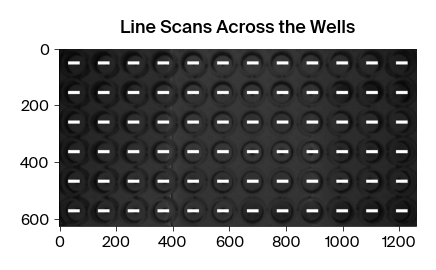

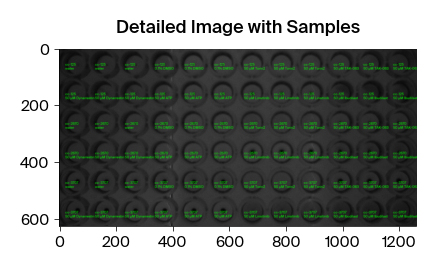

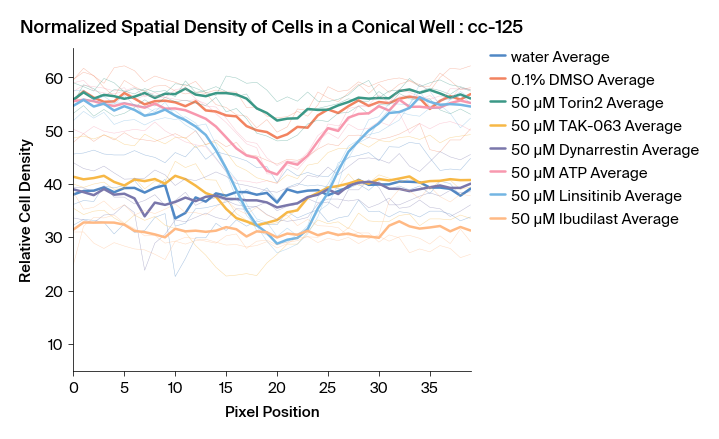

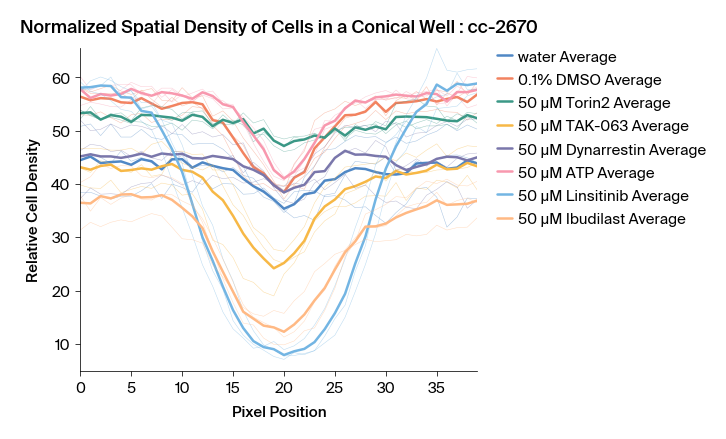

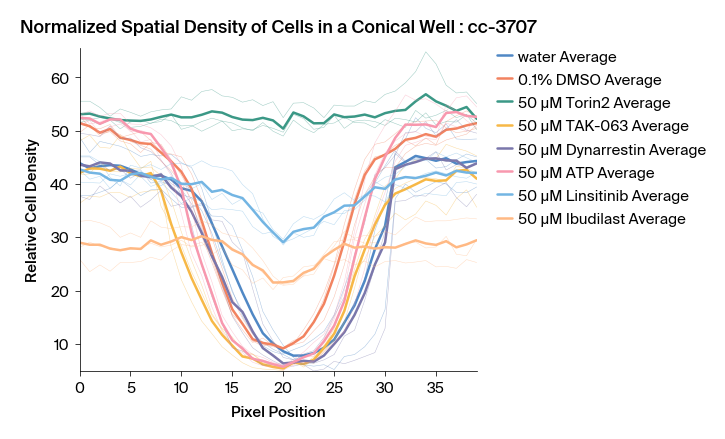

Marked-up image saved to: ../results/linescan_drug_results/marked_well_lines.png
Detailed image saved to: ../results/linescan_drug_results/marked_details.png
Overlayed plots saved as SVG to: ../results/linescan_drug_results/overlayed_plot_cc-3707.svg
Line scan intensities saved to: ../results/linescan_drug_results/line_scans.csv
Minimum intensity points saved to: ../results/linescan_drug_results/min_intensity_points.csv

--- Statistical Analysis for cc-125 ---
                  Min_Intensity                                             \
                          count       mean       std        min        25%   
Treatment                                                                    
0.1% DMSO                   3.0  48.636364  4.464738  43.727273  46.727273   
50 µM ATP                   3.0  41.787879  1.682023  40.090909  40.954545   
50 µM Dynarrestin           3.0  31.757576  7.396857  23.818182  28.409091   
50 µM Ibudilast             3.0  26.848485  2.611692  24.909091  25

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line
import cv2
import os
import pandas as pd
import arcadia_pycolor as apc
from PIL import Image, ImageDraw, ImageFont
import tifffile as tiff
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

# Set the default matplotlib styles using arcadia-pycolor
apc.mpl.setup()

# Correct path to the TIFF file
image_path = '../data/vbottom_avi/cropped_final_frame/algae_growth_curve_00000_1724619978-Crop.tif'

# Verify that the file exists
if not os.path.exists(image_path):
    print(f"Error: File not found at path {image_path}")
    sys.exit()

# Attempt to open the image using tifffile
try:
    image = tiff.imread(image_path)
    print("Image opened successfully!")
except IOError:
    print("Error: Could not open image with tifffile.")
    sys.exit()

# Convert the image to grayscale if it's not already (if needed)
if len(image.shape) > 2:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define the number of rows and columns in the 96-well plate
num_rows = 6
num_cols = 12  # Updated to 12 columns for the current setup

# Diameter and scan width of the wells
well_diameter = 70
scan_width = 10
scan_length = 40  # Updated scan length

# Identify the centers of the wells
height, width = image.shape
row_spacing = height // num_rows
col_spacing = width // num_cols

# Calculate precise center positions of the wells
well_centers = [(int((row + 0.5) * row_spacing), int((col + 0.5) * col_spacing)) for row in range(num_rows) for col in range(num_cols)]

# Create a list of well labels
well_labels = [f'Well {row+1}-{col+1}' for row in range(num_rows) for col in range(num_cols)]

# Create lists to store the line scan results and other metrics
line_scans = []
min_intensity_points = []
diff_avg_min = []
frac_avg_min = []

# Create a copy of the image to draw the lines on
image_with_lines = image.copy()
image_with_details = cv2.cvtColor(image.copy(), cv2.COLOR_GRAY2BGR)

# Updated labels for each well
labels = [
    ['cc-125\nwater', 'cc-125\nwater', 'cc-125\nwater', 'cc-125\n0.1% DMSO', 'cc-125\n0.1% DMSO', 'cc-125\n0.1% DMSO', 'cc-125\n50 µM Torin2', 'cc-125\n50 µM Torin2', 'cc-125\n50 µM Torin2', 'cc-125\n50 µM TAK-063', 'cc-125\n50 µM TAK-063', 'cc-125\n50 µM TAK-063'],
    ['cc-125\n50 µM Dynarrestin', 'cc-125\n50 µM Dynarrestin', 'cc-125\n50 µM Dynarrestin', 'cc-125\n50 µM ATP', 'cc-125\n50 µM ATP', 'cc-125\n50 µM ATP', 'cc-125\n50 µM Linsitinib', 'cc-125\n50 µM Linsitinib', 'cc-125\n50 µM Linsitinib', 'cc-125\n50 µM Ibudilast', 'cc-125\n50 µM Ibudilast', 'cc-125\n50 µM Ibudilast'],
    ['cc-2670\nwater', 'cc-2670\nwater', 'cc-2670\nwater', 'cc-2670\n0.1% DMSO', 'cc-2670\n0.1% DMSO', 'cc-2670\n0.1% DMSO', 'cc-2670\n50 µM Torin2', 'cc-2670\n50 µM Torin2', 'cc-2670\n50 µM Torin2', 'cc-2670\n50 µM TAK-063', 'cc-2670\n50 µM TAK-063', 'cc-2670\n50 µM TAK-063'],
    ['cc-2670\n50 µM Dynarrestin', 'cc-2670\n50 µM Dynarrestin', 'cc-2670\n50 µM Dynarrestin', 'cc-2670\n50 µM ATP', 'cc-2670\n50 µM ATP', 'cc-2670\n50 µM ATP', 'cc-2670\n50 µM Linsitinib', 'cc-2670\n50 µM Linsitinib', 'cc-2670\n50 µM Linsitinib', 'cc-2670\n50 µM Ibudilast', 'cc-2670\n50 µM Ibudilast', 'cc-2670\n50 µM Ibudilast'],
    ['cc-3707\nwater', 'cc-3707\nwater', 'cc-3707\nwater', 'cc-3707\n0.1% DMSO', 'cc-3707\n0.1% DMSO', 'cc-3707\n0.1% DMSO', 'cc-3707\n50 µM Torin2', 'cc-3707\n50 µM Torin2', 'cc-3707\n50 µM Torin2', 'cc-3707\n50 µM TAK-063', 'cc-3707\n50 µM TAK-063', 'cc-3707\n50 µM TAK-063'],
    ['cc-3707\n50 µM Dynarrestin', 'cc-3707\n50 µM Dynarrestin', 'cc-3707\n50 µM Dynarrestin', 'cc-3707\n50 µM ATP', 'cc-3707\n50 µM ATP', 'cc-3707\n50 µM ATP', 'cc-3707\n50 µM Linsitinib', 'cc-3707\n50 µM Linsitinib', 'cc-3707\n50 µM Linsitinib', 'cc-3707\n50 µM Ibudilast', 'cc-3707\n50 µM Ibudilast', 'cc-3707\n50 µM Ibudilast']
]

# Flatten the labels for easier indexing
flat_labels = [label for row in labels for label in row]

# Load the Suisse Int'l font
try:
    font_path = '/path/to/SuisseIntl-Regular.ttf'  # Replace with the actual path to the Suisse Int'l font file
    font = ImageFont.truetype(font_path, 12)
except IOError:
    print("Suisse Int'l font not found. Using default font.")
    font = ImageFont.load_default()

# Convert the image_with_details to PIL format for text drawing
image_with_details_pil = Image.fromarray(cv2.cvtColor(image_with_details, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(image_with_details_pil)

# Perform line scans, calculate metrics (minimum intensity, difference, and fraction)
for i, (center_y, center_x) in enumerate(well_centers):
    # Calculate the start and end points of the scan line
    start_x = max(center_x - scan_length // 2, 0)
    end_x = min(center_x + scan_length // 2, width - 1)
    
    # Perform a horizontal line scan across the center with a width of scan_width
    line_intensity = []
    for offset in range(-scan_width // 2, scan_width // 2 + 1):
        rr, cc = line(center_y + offset, start_x, center_y + offset, end_x)
        line_intensity.append(image[rr, cc])
    
    # Ensure all scans are of the same length by trimming to scan_length
    line_intensity = [scan[:scan_length] for scan in line_intensity]
    line_intensity = np.mean(line_intensity, axis=0)
    
    # Realign the line scan by aligning the minimum point within a broader search region
    broader_search_indices = np.arange(10, 30)  # Adjusted for new scan length
    min_index = broader_search_indices[np.argmin(line_intensity[broader_search_indices])]
    shift = (scan_length // 2) - min_index  # Align the minimum point to the center
    line_intensity = np.roll(line_intensity, shift)
    
    # Store the realigned and normalized result
    line_scans.append(line_intensity)
    
    # Calculate the metrics:
    avg_33_37 = np.mean(line_intensity[33:38])  # Average between pixels 33-37
    min_intensity = np.min(line_intensity)  # Minimum intensity point
    diff_avg_min.append(avg_33_37 - min_intensity)  # Difference between avg (33-37) and min
    frac_avg_min.append(avg_33_37 / min_intensity if min_intensity != 0 else np.nan)  # Fraction of avg over min
    
    # Store the minimum intensity point with its strain and treatment
    min_intensity_points.append({
        'Well': well_labels[i],
        'Strain': flat_labels[i].split('\n')[0],
        'Treatment': flat_labels[i].split('\n')[1],
        'Min_Intensity': min_intensity
    })
    
    # Draw the line on the image for visualization
    for offset in range(-scan_width // 2, scan_width // 2 + 1):
        rr, cc = line(center_y + offset, start_x, center_y + offset, end_x)
        image_with_lines[rr, cc] = 255
    
    # Add sample details to the detailed image using PIL
    draw.text((center_x - 30, center_y), flat_labels[i], font=font, fill=(0, 255, 0))

# Convert back to OpenCV format
image_with_details = cv2.cvtColor(np.array(image_with_details_pil), cv2.COLOR_RGB2BGR)

# Ensure output directories exist
output_dir = '../results/linescan_drug_results'
os.makedirs(output_dir, exist_ok=True)

# Save the images with the lines and details
marked_image_path = os.path.join(output_dir, 'marked_well_lines.png')
details_image_path = os.path.join(output_dir, 'marked_details.png')
cv2.imwrite(marked_image_path, image_with_lines)
cv2.imwrite(details_image_path, image_with_details)

# Display the images with the scanned lines and details
plt.imshow(image_with_lines, cmap='gray')
plt.title('Line Scans Across the Wells')
plt.show()

plt.imshow(image_with_details)
plt.title('Detailed Image with Samples')
plt.show()

# Define the color scheme for treatments
treatment_color_map = {
    'water': '#5088C5',
    '0.1% DMSO': '#F28360',
    '50 µM Torin2': '#3B9886',
    '50 µM TAK-063': '#F7B846',
    '50 µM Dynarrestin': '#7A77AB',
    '50 µM ATP': '#F898AE',
    '50 µM Linsitinib': '#73B5E3',
    '50 µM Ibudilast': '#FFB984'
}

# Find the global minimum and maximum for y-axis across all scans
y_min = min([min(scan) for scan in line_scans])
y_max = max([max(scan) for scan in line_scans])

# Create separate plots for each strain with different treatments
for strain in ['cc-125', 'cc-2670', 'cc-3707']:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot individual scans and averages for each treatment in the current strain
    for treatment in treatment_color_map.keys():
        # Filter the scans that match the current strain and treatment
        treatment_scans = [line_scans[i] for i in range(len(line_scans)) if flat_labels[i].split('\n')[0] == strain and flat_labels[i].split('\n')[1] == treatment]
        
        # Plot the individual scans
        for scan in treatment_scans:
            ax.plot(scan, color=treatment_color_map[treatment], linewidth=0.5, alpha=0.5)
        
        # Plot the average scan
        if treatment_scans:
            avg_scan = np.mean(treatment_scans, axis=0)
            ax.plot(avg_scan, color=treatment_color_map[treatment], linewidth=2.5, label=f'{treatment} Average')

    # Set consistent limits for x and y axes
    ax.set_xlim(0, scan_length - 1)
    ax.set_ylim(y_min, y_max)

    ax.set_title(f'Normalized Spatial Density of Cells in a Conical Well : {strain}', fontstyle='normal')
    ax.set_xlabel('Pixel Position')
    ax.set_ylabel('Relative Cell Density')
    
    # Place the legend outside of the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.tight_layout()
    
    # Save the plot as an SVG file
    overlayed_plot_path = os.path.join(output_dir, f'overlayed_plot_{strain}.svg')
    plt.savefig(overlayed_plot_path, format='svg')
    
    plt.show()

# Convert the line scan results to a DataFrame and export as CSV
line_scans_df = pd.DataFrame(line_scans).T
line_scans_df.columns = well_labels

csv_path = os.path.join(output_dir, 'line_scans.csv')
line_scans_df.to_csv(csv_path, index=False)

print(f"Marked-up image saved to: {marked_image_path}")
print(f"Detailed image saved to: {details_image_path}")
print(f"Overlayed plots saved as SVG to: {overlayed_plot_path}")
print(f"Line scan intensities saved to: {csv_path}")

# Export minimum intensity points as a CSV file
min_intensity_df = pd.DataFrame(min_intensity_points)
min_intensity_df['Diff_Avg_Min'] = diff_avg_min
min_intensity_df['Frac_Avg_Min'] = frac_avg_min

min_intensity_csv_path = os.path.join(output_dir, 'min_intensity_points.csv')
min_intensity_df.to_csv(min_intensity_csv_path, index=False)

print(f"Minimum intensity points saved to: {min_intensity_csv_path}")

# Initialize a list to store the statistical results
stats_results = []

# Independent Statistical Analysis for Each Strain and Metric
for strain in ['cc-125', 'cc-2670', 'cc-3707']:
    print(f"\n--- Statistical Analysis for {strain} ---")
    strain_data = min_intensity_df[min_intensity_df['Strain'] == strain]
    
    # Descriptive statistics for each metric
    desc_stats = strain_data.groupby('Treatment').describe()
    print(desc_stats)
    
    # Loop over the three metrics (Min_Intensity, Diff_Avg_Min, Frac_Avg_Min)
    for metric in ['Min_Intensity', 'Diff_Avg_Min', 'Frac_Avg_Min']:
        print(f"\n--- ANOVA and Tukey for {metric} ---")
        
        # One-way ANOVA
        anova_result = stats.f_oneway(
            *[strain_data[strain_data['Treatment'] == treatment][metric] for treatment in strain_data['Treatment'].unique()]
        )
        print(f"ANOVA result for {metric} in {strain}: F={anova_result.statistic}, p={anova_result.pvalue}")
        
        # If ANOVA is significant, perform post-hoc testing with Tukey's HSD
        if anova_result.pvalue < 0.05:
            tukey_result = pairwise_tukeyhsd(
                strain_data[metric],
                strain_data['Treatment'],
                alpha=0.05
            )
            print(tukey_result)
            # Append Tukey results to the stats_results list
            tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])
            tukey_df['Strain'] = strain
            tukey_df['Metric'] = metric
            stats_results.append(tukey_df)

# Combine all the statistical results into a single DataFrame
if stats_results:
    final_stats_df = pd.concat(stats_results, ignore_index=True)
    stats_csv_path = os.path.join(output_dir, 'statistical_results.csv')
    final_stats_df.to_csv(stats_csv_path, index=False)
    print(f"Statistical results saved to: {stats_csv_path}")